# Data Processing

In [1]:
import csv

In [2]:
with open("password_trainv3.csv") as csv_file:
    reader = csv.reader(csv_file)
    char_ststistics = {}
    for i, row in enumerate(reader):
        if(i == 0): continue
        for c in row[1]:
            if c in char_ststistics: char_ststistics[c] += 1
            else: char_ststistics[c] = 1

In [3]:
values = []
alphapet = ''
for c in sorted(char_ststistics):
    print(c, char_ststistics[c])
    values.append(char_ststistics[c])
    alphapet += c

print(f'min value {min(values)}\nmax value {max(values)}')
print(len(alphapet))
print (alphapet)

! 66
" 72
# 114
$ 99
% 66
& 63
' 84
( 54
) 66
* 96
+ 54
, 72
- 84
. 81
/ 57
0 114
1 120
2 114
3 105
4 138
5 111
6 114
7 99
8 90
9 105
: 57
; 69
< 75
= 84
> 72
? 66
@ 60
A 54
B 78
C 84
D 75
E 84
F 69
G 84
H 54
I 87
J 78
K 39
L 72
M 69
N 78
O 75
P 75
Q 66
R 81
S 81
T 99
U 42
V 69
W 96
X 75
Y 69
Z 72
[ 60
\ 63
] 87
^ 84
_ 54
` 81
a 93
b 69
c 63
d 96
e 60
f 72
g 87
h 87
i 81
j 66
k 66
l 45
m 111
n 114
o 63
p 72
q 69
r 69
s 48
t 69
u 60
v 63
w 81
x 60
y 66
z 63
{ 57
| 63
} 81
~ 60
min value 39
max value 138
94
!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~


In [ ]:
# balanced split


# DataSet.py

In [4]:
from torch.utils.data import Dataset, sampler, DataLoader
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import csv
from PIL import Image
import random

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
class Passwords_data(Dataset):
    def __init__ (self, csv_Path, imgs_path, transformers = None):
        with open(csv_Path, 'r') as csv_file:
            # images names and labels in matching indices
            reader = csv.reader(csv_file)
            self.imgs = []
            self.lables = []
            for i, row in enumerate(reader):
                if i == 0: continue
                self.imgs.append(row[0])
                self.lables.append(row[1])
                
            self.imgs_file = imgs_path
            self.transformers = transformers
    
    def __getitem__(self, index):
        # image
        img_path = self.imgs_file + '/' + self.imgs[index]
        img = Image.open(img_path).convert('L')
        #print(img.size)
        
        # image augmentation
        if self.transformers != None:
            img = self.transformers(img)
        img = transforms.ToTensor()(img)
        # lable
        lable = self.lables[index]
        
        return (img_path, img, lable)
    
    def __len__(self):
        return len(self.imgs)

In [6]:
class ResizeNormalize (object):
    def __init__(self, img_size):
        self.img_size = img_size # imgH, imgW
    
    def __call__(self, img):
        img = transforms.Resize(size=self.img_size)(transforms.ToPILImage()(img))
        img = transforms.ToTensor()(img)
        img.sub_(0.5).div_(0.5) # normalize gray scale
        return img

In [7]:
class AlignBatch(object):
    def __init__(self, imgH = 32, imgW = 100, keep_ratio = True, min_ratio = 1, padding = False):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio = keep_ratio
        self.min_ratio = min_ratio
        self.padding = padding
        
    def __call__(self, batch):
        img_paths, imgs, lables = zip(*batch)
        imgH = self.imgH
        imgW = self.imgW
        
        if(self.keep_ratio):
            max_ratio = 0
            for img in imgs:
                #print(img.shape)
                _, h, w = img.shape
                if max_ratio < (w/h): max_ratio = (w/h)
            if self.padding:
                imgs_padded = []
                for i, img in enumerate(imgs):
                    _, h, w = img.shape
                    w_new = h * max_ratio
                    pad = int((w_new - w) / 2)
                    #print(img.shape)
                    imgs_padded.append(F.pad(img, (pad, pad), "constant"))
                imgs = imgs_padded
            
            imgW = int(max_ratio * imgH)
            
        resizer = ResizeNormalize((imgH, imgW))
        imgs = [resizer(img).unsqueeze(0) for img in imgs]
        imgs = torch.cat(imgs, 0)
        return img_paths, imgs, lables
                    

In [8]:
class MatchingSampler(sampler.Sampler):
    
    def __init__ (self, data_source, batch_size):
        self.data_source = data_source
        self.number_sampels = len(data_source)
        self.batch_size = batch_size
        
    def __iter__ (self):
        n_batches = len(self)//self.batch_size
        tail = len(self) % self.batch_size
        index = torch.LongTensor(len(self)).fill_(0)
        for i in range(n_batches):
            random_start = random.randint(0, len(self)-self.batch_size)
            b_indx = random_start + torch.arange(0, self.batch_size)
            index[i*self.batch_size : (i+1) * self.batch_size] = b_indx
        if tail:
            random_start = random.randint(0, len(self)-tail)
            b_indx = random_start + torch.arange(0, tail-1)
            index[n_batches * self.batch_size:] = b_indx
            
        return iter(index)
        
    def __len__(self):
        return self.number_sampels

torch.Size([1, 32, 228])


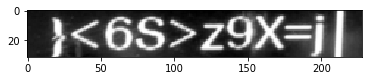

}<6S>z9X=j|
torch.Size([1, 32, 228])


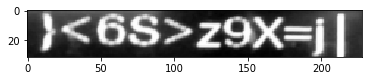

}<6S>z9X=j|
torch.Size([1, 32, 228])


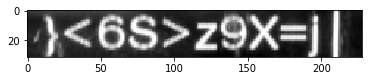

}<6S>z9X=j|
torch.Size([1, 32, 228])


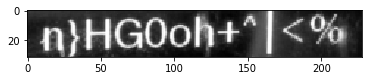

n}HG0oh+^|<%


In [9]:
dataset = Passwords_data('password_trainv3.csv', 'train_passwordv3')

sampler = MatchingSampler(dataset, 4)
align = AlignBatch()
dataloder = DataLoader(dataset, batch_size=4, collate_fn=align, shuffle= False)

img_pathes, imgs, lables = next(iter(dataloder))

for sample in zip(img_pathes, imgs, lables):
    #print(sample)
    img_path, img, lable = sample
    print(img.shape)
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.show()
    print(lable)

# Model

In [10]:
import torch.nn as nn

In [11]:
class BiDrictionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BiDrictionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    
    def forward(self, input):
        recurrent, _ = self.rnn(input)
        t_steps, b_size, h_num = recurrent.shape
        recurrent = recurrent.view(t_steps*b_size, h_num) # prepare the linear layer input
        
        output = self.embedding(recurrent)
        output = output.view(t_steps, b_size, -1)
        
        return output

In [ ]:
'''
class ConvLayer(nn.Module):
    def __init__(self, inFilt, outFilt, kerSiz, padSiz, strideSiz, b_n = False):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(inFilt, outFilt, kerSiz, padSiz, strideSiz)
        self.relu = nn.ReLU(inplace=True)
    
    def
'''

In [12]:
class CRNN(nn.Module):
    def __init__(self, imgH, inChannal, nClasses, nHidden, nLSTMs = 2):
        super(CRNN, self).__init__()
        assert imgH == 32 , 'the image input hight must be 32'
        
        ks = [3, 3, 3, 3, 3, 3, 2] # kernal Size
        ps = [1, 1, 1, 1, 1, 1, 0] # padding
        ss = [1, 1, 1, 1, 1, 1, 1] # stride
        fn = [64, 128, 256, 256, 512, 512, 512] # filters number
        
        cnn = nn.Sequential()
        
        
        def conv_layer(layNum, b_n = False):
            nIn = inChannal if layNum == 0 else fn[layNum-1]
            nOut = fn[layNum]
            # Conv Layer
            cnn.add_module(f'conv{layNum}', nn.Conv2d(nIn, nOut, ks[layNum], ss[layNum], ps[layNum]))
            # btach normalization
            if b_n:
                cnn.add_module(f'batchnorm{layNum}', nn.BatchNorm2d(nOut))
            # non Linearity (ReLU)
            cnn.add_module(f'relu{layNum}', nn.ReLU(inplace=True))
            
        # Cnn Arch
        conv_layer(0)
        cnn.add_module(f'pooling{0}', nn.MaxPool2d(2, 2))  # 64 x 16
        conv_layer(1)
        cnn.add_module(f'pooling{1}', nn.MaxPool2d(2, 2))  # 128 x 8
        conv_layer(2, b_n=True)
        conv_layer(3)
        # the irregular shape of stride and padding beacause of the shape of some char like (i, ..)
        cnn.add_module(f'pooling{2}', nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 256 x 4
        conv_layer(4, b_n=True)
        conv_layer(5)
        cnn.add_module(f'pooling{3}', nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 512 x 2
        conv_layer(6, b_n=True) #  512 x 1

        self.cnn = cnn

        # Rnn Arch
        rnn = nn.Sequential(
            BiDrictionalLSTM(512, nHidden, nHidden),
            BiDrictionalLSTM(nHidden, nHidden, nClasses)
        )

        self.rnn = rnn
        
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input):
        # cnn pass
        conv = self.cnn(input)
        b, c, h, w = conv.shape
        
        assert h == 1, 'the hight after cnn must equal 1'
        
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1) # sequance, batch, features
        
        # rnn pass 
        rnn = self.rnn(conv)
        
        output = self.softmax(rnn)
        
        return output


In [ ]:
crnn = CRNN(32, 1, 37, 256)

In [ ]:
crnn.load_state_dict(torch.load('crnn.pth'))

In [ ]:
# model state dict
st = crnn.state_dict()
for name in st:
    print(name)

In [ ]:
# checkpoint state dic
st = torch.load('crnn.pth')
for name,k in st.items():
    print(name)

# Utilties

## Logger

In [13]:
import tensorflow as tf


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def list_of_scalars_summary(self, tag_value_pairs, step):
        """Log scalar variables."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value) for tag, value in tag_value_pairs])
        self.writer.add_summary(summary, step)

## Label String Convertion

In [14]:
class strLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.abc.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t]), [i - 1 for i in t]
            else:
                char_list = []
                lables_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                        lables_list.append(t[i] - 1)
                return ''.join(char_list), lables_list
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            lables = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                text, lable = self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw)
                texts.append(text)
                lables.append(lable)
                index += l
            return texts, lables

# Training

In [15]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import PIL
import time
import collections

import os

In [16]:
os.makedirs('checkpoints', exist_ok=True)

## Test Tranforms

In [ ]:
train_transforms = transforms.Compose([transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, translate=(.03,.03))])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, scale=(.95,1.05))])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, shear=20)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(degrees=3, expand=True), 
                                       transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomPerspective()])

In [ ]:
dataset = Passwords_data('password_trainv3.csv', 'train_passwordv3', transformers=train_transforms)

sampler = MatchingSampler(dataset, 4)
align = AlignBatch()
dataloder = DataLoader(dataset, batch_size=4, collate_fn=align, shuffle= True)

img_pathes, imgs, lables = next(iter(dataloder))
#print(converter.encode(lables))

for sample in zip(img_pathes, imgs, lables):
    #print(sample)
    img_path, img, lable = sample
    print(img.shape)
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.show()
    print(lable)

## continue training

In [17]:
# training variables 
epochs_num = 100
batch_size = 16
cuda = torch.cuda.is_available()
n_workers = 4
nClasses = len(char_ststistics) + 1
inChannels = 1
imgH = 32
nHidden = 256
lr = .001
test_display = 4
val_each = 1
use_pretrained = True
pre_trained = 'crnn.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'detect cuda device? {cuda}')
print(f'number of classes id {nClasses-1} + blank')

detect cuda device? True
number of classes id 94 + blank


In [18]:
train_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms.RandomAffine(degrees=0, translate=(.03,.03)),
            transforms.RandomAffine(degrees=0, scale=(.95,1.05)),
            transforms.RandomAffine(degrees=0, shear=20),
            transforms.RandomRotation(degrees=3, expand=True)]),
        transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3)],  p=0.5)])

In [19]:
train_dataset = Passwords_data('password_train.csv', 'train_passwordv3', transformers=train_transforms)

#sampler = MatchingSampler(dataset, batch_size)
align = AlignBatch()
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, collate_fn=align, 
                       shuffle= True, num_workers=n_workers)

In [20]:
val_dataset = Passwords_data('password_val.csv', 'train_passwordv3')

#sampler = MatchingSampler(dataset, batch_size)
align = AlignBatch()
val_dataloder = DataLoader(val_dataset, batch_size=batch_size, collate_fn=align, 
                       shuffle= True, num_workers=n_workers)

In [21]:
converter = strLabelConverter(alphapet, ignore_case=False)
criterion = nn.CTCLoss()

In [22]:
def weights_init(m):
    class_name = m.__class__.__name__
    if class_name.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [23]:
crnn = CRNN(imgH, inChannels, nClasses, nHidden)
crnn.apply(weights_init)
if use_pretrained :
    model_dict = crnn.state_dict() # state of the current model
    pretrained_dict = torch.load(pre_trained) # state of the pretrained model
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k != 'rnn.1.embedding.weight' and k != 'rnn.1.embedding.bias'} # remove the classifier from the state
    classifier_dict = {k: v for k, v in model_dict.items() if k == 'rnn.1.embedding.weight' or k == 'rnn.1.embedding.bias'} # get the classifier weight from new model
    pretrained_dict.update(classifier_dict) # update without classifier
    crnn.load_state_dict(pretrained_dict)
    
print(crnn)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

In [24]:
if cuda :
    crnn = crnn.to(device)
    criterion = criterion.to(device)

In [25]:
optimizer = optim.Adam(crnn.parameters(), lr=lr)

In [26]:
# define logger file
os.makedirs('logs', exist_ok=True)
logger = Logger('logs')

In [27]:
def train(model, criterion, optimizer, logger, train_dataloder, batch_size, epoch_num):
    model.train()
    epoch_loss = 0
    samples_num = 0
    
    for batch_i, (_, imgs, targets) in enumerate(train_dataloder):
        batches_done = len(train_dataloder) * epoch_num + batch_i
        samples_num += imgs.shape[0]
        
        # move to device and create variables
        imgs = Variable(imgs.to(device))
        targets, lenghts = converter.encode(targets)
        targets = Variable(targets.to(device), requires_grad=False)
        t_lens = Variable(lenghts, requires_grad=False)
        
        # pass to the network
        preds = model(imgs)
        preds_size = Variable(torch.IntTensor([preds.shape[0]] * imgs.shape[0]))
        
        # loss
        #print(preds_size.shape)
        loss = criterion(preds, targets.cpu(), preds_size, t_lens)
        epoch_loss += loss * imgs.shape[0]
        logger.scalar_summary('loss_batches', loss, batches_done)
        print(f'Epoch {epoch_num}, Batch {batch_i}/{len(train_dataloder)} : Loss = {loss}')
        
        # optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    epoch_loss /= samples_num
    logger.scalar_summary('loss_epochs', epoch_loss, epoch_num)
    
    return epoch_loss

In [28]:
def val(model, criterion, logger, val_dataloder, epoch_num, batch_size=16):
    model.eval()
    
    nCorrect_words = 0
    #nCorrect_chars = 0
    val_loss = 0
    samples_num = 0
    
    for batch_i, (_, imgs, targets) in enumerate(val_dataloder):
        samples_num += imgs.shape[0]
        
        # move to device and create variables
        imgs = Variable(imgs.to(device), requires_grad=False)
        targets_encoded, lenghts = converter.encode(targets)
        targets_encoded = Variable(targets_encoded.to(device), requires_grad=False)
        t_lens = Variable(lenghts, requires_grad=False)
        
        with torch.no_grad():
            # pass to the network
            preds = model(imgs)
            preds_size = Variable(torch.IntTensor([preds.shape[0]] * imgs.shape[0]))

            # loss
            loss = criterion(preds, targets_encoded.cpu(), preds_size, t_lens)
            val_loss += loss * imgs.shape[0]
            
            # get the nework prediction
            _, preds = preds.max(2)
            preds = preds.transpose(1,0).contiguous().view(-1)
            words_preds, lables_preds = converter.decode(preds, preds_size)
            
            for word_pred, target in zip(words_preds, targets):
                if word_pred == target:
                    nCorrect_words += 1
    
    # display some of the network prediction
    row_preds, _ = converter.decode(preds, preds_size, raw=True)[:test_display]

    for row_pred, word_pred, gt in zip(row_preds, words_preds, targets):
        print(f'{row_pred} => {word_pred}, Ground Truth is {gt}')
    
    #compute loss and accurcy
    word_accurcy = nCorrect_words / samples_num
    val_loss /= samples_num
    logger.scalar_summary('val_loss', val_loss, epoch_num)
    logger.scalar_summary('val_WordAccurcy', word_accurcy, epoch_num)
    
    return val_loss, word_accurcy

In [29]:
best_acc = 0
for epoch in range(epochs_num):
    
    tick = time.time()
    train_loss = train(crnn, criterion, optimizer, logger, 
                       train_dataloder, batch_size, epoch)
    tock = time.time()
    
    print(f'Epoch {epoch} finished in {(tock - tick) / 60} minutes')
    print(f'Epoch {epoch} training_loss = {train_loss}')
    
    if epoch % val_each == 0:
        val_loss, val_accurcy = val(crnn, criterion, logger, val_dataloder,
                                    epoch, batch_size)
        print(f'Epoch {epoch} val_loss = {val_loss}, word_accuracy = {val_accurcy}')
            
        # save best checkpoint
        if best_acc <= val_accurcy:
            best_acc = val_accurcy
            checkpoint = {'input_hight':32,
                          'output_size':len(alphapet)+1,
                          'alphapet':alphapet,
                          'train_transforms':train_transforms,
                          'optim_dic':optimizer.state_dict(),
                          'state_dic':crnn.state_dict(),
                          'epoch':epoch
                         }
            torch.save(checkpoint,'checkpoints/best_checkpoint.pth')
    
    # save last epoch
    checkpoint = {'input_hight':32,
                  'output_size':len(alphapet)+1,
                  'alphapet':alphapet,
                  'train_transforms':train_transforms,
                  'optim_dic':optimizer.state_dict(),
                  'state_dic':crnn.state_dict(),
                  'epoch':epoch
                 }
    torch.save(checkpoint,'checkpoints/last_checkpoint.pth')
    
print(f'the best accurcay is {best_acc}')
            

Epoch 0, Batch 0/32 : Loss = 20.01679229736328
Epoch 0, Batch 1/32 : Loss = 20.371015548706055
Epoch 0, Batch 2/32 : Loss = 21.97369956970215
Epoch 0, Batch 3/32 : Loss = 17.863319396972656
Epoch 0, Batch 4/32 : Loss = 17.32358169555664
Epoch 0, Batch 5/32 : Loss = 14.57248306274414
Epoch 0, Batch 6/32 : Loss = 13.094563484191895
Epoch 0, Batch 7/32 : Loss = 10.318499565124512
Epoch 0, Batch 8/32 : Loss = 8.31141471862793
Epoch 0, Batch 9/32 : Loss = 6.312054634094238
Epoch 0, Batch 10/32 : Loss = 5.199183464050293
Epoch 0, Batch 11/32 : Loss = 4.747130393981934
Epoch 0, Batch 12/32 : Loss = 4.83128547668457
Epoch 0, Batch 13/32 : Loss = 5.124048233032227
Epoch 0, Batch 14/32 : Loss = 5.444733142852783
Epoch 0, Batch 15/32 : Loss = 5.670377731323242
Epoch 0, Batch 16/32 : Loss = 5.671440601348877
Epoch 0, Batch 17/32 : Loss = 5.710597038269043
Epoch 0, Batch 18/32 : Loss = 5.50178337097168
Epoch 0, Batch 19/32 : Loss = 5.337872505187988
Epoch 0, Batch 20/32 : Loss = 5.098989486694336
E

Epoch 4, Batch 0/32 : Loss = 3.659669876098633
Epoch 4, Batch 1/32 : Loss = 3.6335577964782715
Epoch 4, Batch 2/32 : Loss = 3.5150325298309326
Epoch 4, Batch 3/32 : Loss = 3.4759788513183594
Epoch 4, Batch 4/32 : Loss = 3.392533779144287
Epoch 4, Batch 5/32 : Loss = 3.4705770015716553
Epoch 4, Batch 6/32 : Loss = 3.4189515113830566
Epoch 4, Batch 7/32 : Loss = 3.5661818981170654
Epoch 4, Batch 8/32 : Loss = 3.424992561340332
Epoch 4, Batch 9/32 : Loss = 3.2429518699645996
Epoch 4, Batch 10/32 : Loss = 3.1485354900360107
Epoch 4, Batch 11/32 : Loss = 3.083436965942383
Epoch 4, Batch 12/32 : Loss = 3.0631425380706787
Epoch 4, Batch 13/32 : Loss = 3.1195287704467773
Epoch 4, Batch 14/32 : Loss = 3.23420786857605
Epoch 4, Batch 15/32 : Loss = 2.9789061546325684
Epoch 4, Batch 16/32 : Loss = 3.008449077606201
Epoch 4, Batch 17/32 : Loss = 3.091019630432129
Epoch 4, Batch 18/32 : Loss = 2.956968307495117
Epoch 4, Batch 19/32 : Loss = 2.7396697998046875
Epoch 4, Batch 20/32 : Loss = 2.9363453

Epoch 8, Batch 0/32 : Loss = 0.2218661904335022
Epoch 8, Batch 1/32 : Loss = 0.4220491051673889
Epoch 8, Batch 2/32 : Loss = 0.4126681685447693
Epoch 8, Batch 3/32 : Loss = 0.2537296712398529
Epoch 8, Batch 4/32 : Loss = 0.14774686098098755
Epoch 8, Batch 5/32 : Loss = 0.14554472267627716
Epoch 8, Batch 6/32 : Loss = 0.15946334600448608
Epoch 8, Batch 7/32 : Loss = 0.18833039700984955
Epoch 8, Batch 8/32 : Loss = 0.1531006246805191
Epoch 8, Batch 9/32 : Loss = 0.4207683205604553
Epoch 8, Batch 10/32 : Loss = 0.17777591943740845
Epoch 8, Batch 11/32 : Loss = 0.1980592906475067
Epoch 8, Batch 12/32 : Loss = 0.21464583277702332
Epoch 8, Batch 13/32 : Loss = 0.16967032849788666
Epoch 8, Batch 14/32 : Loss = 0.19698956608772278
Epoch 8, Batch 15/32 : Loss = 0.47624337673187256
Epoch 8, Batch 16/32 : Loss = 0.16868478059768677
Epoch 8, Batch 17/32 : Loss = 0.2140936255455017
Epoch 8, Batch 18/32 : Loss = 0.13635307550430298
Epoch 8, Batch 19/32 : Loss = 0.45144665241241455
Epoch 8, Batch 20/

-----dd-----!--NN-------r---AA----j---*----$-----33----hh-----5-----n----- => d!NrAj*$3h5n, Ground Truth is d!NrAj*$3h5n
-----C-----DD----E----gg----m------"---mm------F----<-----Q----88----2---- => CDEgm"mF<Q82, Ground Truth is CDEgm"mF<Q82
------C-----RR-----;---9------y----??----22-----d-----ii--OO------{---!--- => CR;9y?2diO{!, Ground Truth is cR;9y?2diO{!
------zz-----O-----"----GG-------/-----~------$------c-----1----jj---t---- => zO"G/~$c1jt, Ground Truth is z0"G/~$c1jt
Epoch 11 val_loss = 0.5236402153968811, word_accuracy = 0.58
Epoch 12, Batch 0/32 : Loss = 0.04485951364040375
Epoch 12, Batch 1/32 : Loss = 0.06273914873600006
Epoch 12, Batch 2/32 : Loss = 0.10512404143810272
Epoch 12, Batch 3/32 : Loss = 0.07843194156885147
Epoch 12, Batch 4/32 : Loss = 0.06385329365730286
Epoch 12, Batch 5/32 : Loss = 0.058190539479255676
Epoch 12, Batch 6/32 : Loss = 0.10689099878072739
Epoch 12, Batch 7/32 : Loss = 0.05898717790842056
Epoch 12, Batch 8/32 : Loss = 0.03824838995933533
Epoch 

Epoch 15, Batch 24/32 : Loss = 0.07630486786365509
Epoch 15, Batch 25/32 : Loss = 0.08049128204584122
Epoch 15, Batch 26/32 : Loss = 0.089272640645504
Epoch 15, Batch 27/32 : Loss = 0.033135488629341125
Epoch 15, Batch 28/32 : Loss = 0.15749669075012207
Epoch 15, Batch 29/32 : Loss = 0.15937215089797974
Epoch 15, Batch 30/32 : Loss = 0.08390744030475616
Epoch 15, Batch 31/32 : Loss = 0.07516008615493774
Epoch 15 finished in 0.042635480562845864 minutes
Epoch 15 training_loss = 0.07424699515104294
----kk---$---|---'---99---Y----N-----W------m------T---8----- => k$|'9YNWmT8, Ground Truth is k$|',9YNWmT8
---"----]--t---4---------^----W--------Q----44---->-----g---- => "]t4^WQ4>g, Ground Truth is "]t4e^WQ4>g
---BB----.---Y---l--W-------6----F----hh----X---'--Y----2---- => B.YlW6FhX'Y2, Ground Truth is B.YIW6FhX'Y2
-----cc---RR----;--99----y----?---22----d----i---O-----{--!-- => cR;9y?2diO{!, Ground Truth is cR;9y?2diO{!
Epoch 15 val_loss = 0.5027710795402527, word_accuracy = 0.64
Epoch 16,

Epoch 19, Batch 10/32 : Loss = 0.01851266622543335
Epoch 19, Batch 11/32 : Loss = 0.1398165076971054
Epoch 19, Batch 12/32 : Loss = 0.037405237555503845
Epoch 19, Batch 13/32 : Loss = 0.013355277478694916
Epoch 19, Batch 14/32 : Loss = 0.11632584035396576
Epoch 19, Batch 15/32 : Loss = 0.15068380534648895
Epoch 19, Batch 16/32 : Loss = 0.07509665936231613
Epoch 19, Batch 17/32 : Loss = 0.019024036824703217
Epoch 19, Batch 18/32 : Loss = 0.10234421491622925
Epoch 19, Batch 19/32 : Loss = 0.015141695737838745
Epoch 19, Batch 20/32 : Loss = 0.030203353613615036
Epoch 19, Batch 21/32 : Loss = 0.078713059425354
Epoch 19, Batch 22/32 : Loss = 0.12654556334018707
Epoch 19, Batch 23/32 : Loss = 0.13168081641197205
Epoch 19, Batch 24/32 : Loss = 0.01684965193271637
Epoch 19, Batch 25/32 : Loss = 0.013646194711327553
Epoch 19, Batch 26/32 : Loss = 0.019188838079571724
Epoch 19, Batch 27/32 : Loss = 0.016220280900597572
Epoch 19, Batch 28/32 : Loss = 0.07310077548027039
Epoch 19, Batch 29/32 : Lo

Epoch 23, Batch 0/32 : Loss = 0.01592218317091465
Epoch 23, Batch 1/32 : Loss = 0.02434641495347023
Epoch 23, Batch 2/32 : Loss = 0.02632610872387886
Epoch 23, Batch 3/32 : Loss = 0.009746566414833069
Epoch 23, Batch 4/32 : Loss = 0.007985658943653107
Epoch 23, Batch 5/32 : Loss = 0.013876061886548996
Epoch 23, Batch 6/32 : Loss = 0.018599864095449448
Epoch 23, Batch 7/32 : Loss = 0.030043262988328934
Epoch 23, Batch 8/32 : Loss = 0.02110685035586357
Epoch 23, Batch 9/32 : Loss = 0.070782870054245
Epoch 23, Batch 10/32 : Loss = 0.015270286239683628
Epoch 23, Batch 11/32 : Loss = 0.02290547452867031
Epoch 23, Batch 12/32 : Loss = 0.016522802412509918
Epoch 23, Batch 13/32 : Loss = 0.007376984693109989
Epoch 23, Batch 14/32 : Loss = 0.04929715767502785
Epoch 23, Batch 15/32 : Loss = 0.037638887763023376
Epoch 23, Batch 16/32 : Loss = 0.04477442055940628
Epoch 23, Batch 17/32 : Loss = 0.018798381090164185
Epoch 23, Batch 18/32 : Loss = 0.12630046904087067
Epoch 23, Batch 19/32 : Loss = 0.

---/----MMM------o----EE----^^---3-----X----/---&&----66-----X------ => /MoE^3X/&6X, Ground Truth is /MoE^3x/&6X
----{---B------Y----R----aa----y---hh---#-----2---->----EE----44---- => {BYRayh#2>E4, Ground Truth is {BYRayh#2>E4
---J---;--qq----++---/---z----y---UU-----%%------U-----11---x---__-- => J;q+/zyU%U1x_, Ground Truth is J;q+/zyU%U1x_
---"----]---t---44----e-----^----W--------Q-------44--->>-----gg---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 26 val_loss = 0.5310602188110352, word_accuracy = 0.69
Epoch 27, Batch 0/32 : Loss = 0.016999103128910065
Epoch 27, Batch 1/32 : Loss = 0.01571406051516533
Epoch 27, Batch 2/32 : Loss = 0.04085012525320053
Epoch 27, Batch 3/32 : Loss = 0.010768542066216469
Epoch 27, Batch 4/32 : Loss = 0.012272440828382969
Epoch 27, Batch 5/32 : Loss = 0.04899726063013077
Epoch 27, Batch 6/32 : Loss = 0.1122015044093132
Epoch 27, Batch 7/32 : Loss = 0.02930767834186554
Epoch 27, Batch 8/32 : Loss = 0.12850235402584076
Epoch 27, Batch 9/32 : Loss =

Epoch 30, Batch 19/32 : Loss = 0.0083196135237813
Epoch 30, Batch 20/32 : Loss = 0.09378185868263245
Epoch 30, Batch 21/32 : Loss = 0.007010996341705322
Epoch 30, Batch 22/32 : Loss = 0.012264009565114975
Epoch 30, Batch 23/32 : Loss = 0.010769091546535492
Epoch 30, Batch 24/32 : Loss = 0.024650195613503456
Epoch 30, Batch 25/32 : Loss = 0.006684851832687855
Epoch 30, Batch 26/32 : Loss = 0.010008025914430618
Epoch 30, Batch 27/32 : Loss = 0.034486547112464905
Epoch 30, Batch 28/32 : Loss = 0.02658650651574135
Epoch 30, Batch 29/32 : Loss = 0.01133674755692482
Epoch 30, Batch 30/32 : Loss = 0.010387195274233818
Epoch 30, Batch 31/32 : Loss = 0.05730655789375305
Epoch 30 finished in 0.043453677495320635 minutes
Epoch 30 training_loss = 0.02875337563455105
--44---r--{---%------/--'-)---w-----&----N------+---P------ => 4r{%/')w&N+P, Ground Truth is 4r{%/')w&N+P
----dd---!--N-----r---A----j--*---$---33---hh---55---n----- => d!NrAj*$3h5n, Ground Truth is d!NrAj*$3h5n
----Y----W------]--i-\\

Epoch 34, Batch 6/32 : Loss = 0.011891201138496399
Epoch 34, Batch 7/32 : Loss = 0.10655810683965683
Epoch 34, Batch 8/32 : Loss = 0.011752600781619549
Epoch 34, Batch 9/32 : Loss = 0.015797467902302742
Epoch 34, Batch 10/32 : Loss = 0.013171333819627762
Epoch 34, Batch 11/32 : Loss = 0.08788221329450607
Epoch 34, Batch 12/32 : Loss = 0.02597935125231743
Epoch 34, Batch 13/32 : Loss = 0.005392485298216343
Epoch 34, Batch 14/32 : Loss = 0.009206283837556839
Epoch 34, Batch 15/32 : Loss = 0.00615257304161787
Epoch 34, Batch 16/32 : Loss = 0.015401997603476048
Epoch 34, Batch 17/32 : Loss = 0.01728394627571106
Epoch 34, Batch 18/32 : Loss = 0.007388126105070114
Epoch 34, Batch 19/32 : Loss = 0.005812538787722588
Epoch 34, Batch 20/32 : Loss = 0.06558314710855484
Epoch 34, Batch 21/32 : Loss = 0.00897958967834711
Epoch 34, Batch 22/32 : Loss = 0.07430063188076019
Epoch 34, Batch 23/32 : Loss = 0.013472095131874084
Epoch 34, Batch 24/32 : Loss = 0.11595921963453293
Epoch 34, Batch 25/32 : L

-----0----JJ---!--(--;--AA----33---,--'--)--r---r---77---- => 0J!(;A3,')rr7, Ground Truth is 0J!(;A3,')rr7
----dd----R---;--99---y----?---22---dd---i--O-----{--!---- => dR;9y?2diO{!, Ground Truth is cR;9y?2diO{!
-:------3----\----$---->>-----S-----\----MM-----i--BB----- => :-3\$>S\MiB, Ground Truth is :-3\$>S\MiB
----4---r---{--%%-----/--`--)--w-----&&---N------+---P---- => 4r{%/`)w&N+P, Ground Truth is 4r{%/')w&N+P
Epoch 37 val_loss = 0.5706621408462524, word_accuracy = 0.66
Epoch 38, Batch 0/32 : Loss = 0.19900956749916077
Epoch 38, Batch 1/32 : Loss = 0.009420474991202354
Epoch 38, Batch 2/32 : Loss = 0.013406418263912201
Epoch 38, Batch 3/32 : Loss = 0.08417503535747528
Epoch 38, Batch 4/32 : Loss = 0.012626741081476212
Epoch 38, Batch 5/32 : Loss = 0.0067283995449543
Epoch 38, Batch 6/32 : Loss = 0.021632933989167213
Epoch 38, Batch 7/32 : Loss = 0.00565203744918108
Epoch 38, Batch 8/32 : Loss = 0.007319361437112093
Epoch 38, Batch 9/32 : Loss = 0.022269174456596375
Epoch 38, Batc

Epoch 41, Batch 21/32 : Loss = 0.03038225695490837
Epoch 41, Batch 22/32 : Loss = 0.016071531921625137
Epoch 41, Batch 23/32 : Loss = 0.04434879869222641
Epoch 41, Batch 24/32 : Loss = 0.005566623527556658
Epoch 41, Batch 25/32 : Loss = 0.28599122166633606
Epoch 41, Batch 26/32 : Loss = 0.01444239355623722
Epoch 41, Batch 27/32 : Loss = 0.008862178772687912
Epoch 41, Batch 28/32 : Loss = 0.1058935672044754
Epoch 41, Batch 29/32 : Loss = 0.008719351142644882
Epoch 41, Batch 30/32 : Loss = 0.008503518998622894
Epoch 41, Batch 31/32 : Loss = 0.033613819628953934
Epoch 41 finished in 0.04294631481170654 minutes
Epoch 41 training_loss = 0.042135149240493774
---##----G-----9----E---I--=----h---55---#----2----J---)--k----- => #G9EI=h5#2J)k, Ground Truth is #G9EI=h5#2J)k
---{--BB-----Y----R----aa---y----h---#----2---->>----E----4----- => {BYRayh#2>E4, Ground Truth is {BYRayh#2>E4
---z----0-----"---GGG-----/----~~----$$-----c-----1---j---t----- => z0"G/~$c1jt, Ground Truth is z0"G/~$c1jt
---C--

Epoch 45, Batch 8/32 : Loss = 0.007273559458553791
Epoch 45, Batch 9/32 : Loss = 0.033350326120853424
Epoch 45, Batch 10/32 : Loss = 0.0038203734438866377
Epoch 45, Batch 11/32 : Loss = 0.30839043855667114
Epoch 45, Batch 12/32 : Loss = 0.0890103429555893
Epoch 45, Batch 13/32 : Loss = 0.00496981805190444
Epoch 45, Batch 14/32 : Loss = 0.02266310527920723
Epoch 45, Batch 15/32 : Loss = 0.0027631621342152357
Epoch 45, Batch 16/32 : Loss = 0.01484375074505806
Epoch 45, Batch 17/32 : Loss = 0.014357134699821472
Epoch 45, Batch 18/32 : Loss = 0.07487907260656357
Epoch 45, Batch 19/32 : Loss = 0.004704214166849852
Epoch 45, Batch 20/32 : Loss = 0.02970922738313675
Epoch 45, Batch 21/32 : Loss = 0.004832460545003414
Epoch 45, Batch 22/32 : Loss = 0.01929674856364727
Epoch 45, Batch 23/32 : Loss = 0.006230478174984455
Epoch 45, Batch 24/32 : Loss = 0.004870887380093336
Epoch 45, Batch 25/32 : Loss = 0.005678072571754456
Epoch 45, Batch 26/32 : Loss = 0.023642154410481453
Epoch 45, Batch 27/32

Epoch 49, Batch 0/32 : Loss = 0.003646902274340391
Epoch 49, Batch 1/32 : Loss = 0.01492699421942234
Epoch 49, Batch 2/32 : Loss = 0.0033985725603997707
Epoch 49, Batch 3/32 : Loss = 0.0039033072534948587
Epoch 49, Batch 4/32 : Loss = 0.01036953553557396
Epoch 49, Batch 5/32 : Loss = 0.04089135676622391
Epoch 49, Batch 6/32 : Loss = 0.026826195418834686
Epoch 49, Batch 7/32 : Loss = 0.010076514445245266
Epoch 49, Batch 8/32 : Loss = 0.004615632817149162
Epoch 49, Batch 9/32 : Loss = 0.007368146907538176
Epoch 49, Batch 10/32 : Loss = 0.0026864707469940186
Epoch 49, Batch 11/32 : Loss = 0.0037090517580509186
Epoch 49, Batch 12/32 : Loss = 0.0031075631268322468
Epoch 49, Batch 13/32 : Loss = 0.007015001028776169
Epoch 49, Batch 14/32 : Loss = 0.055939931422472
Epoch 49, Batch 15/32 : Loss = 0.003327911952510476
Epoch 49, Batch 16/32 : Loss = 0.005821590311825275
Epoch 49, Batch 17/32 : Loss = 0.015004139393568039
Epoch 49, Batch 18/32 : Loss = 0.0035868072882294655
Epoch 49, Batch 19/32 

Epoch 52, Batch 28/32 : Loss = 0.03621332347393036
Epoch 52, Batch 29/32 : Loss = 0.006159237585961819
Epoch 52, Batch 30/32 : Loss = 0.007893625646829605
Epoch 52, Batch 31/32 : Loss = 0.027532879263162613
Epoch 52 finished in 0.04515417019526164 minutes
Epoch 52 training_loss = 0.028707200661301613
---dd---!--NN----rr--A---jj-**--$----3---hh---55---n--- => d!NrAj*$3h5n, Ground Truth is d!NrAj*$3h5n
--{--B----Y----R---aa---y--hh--#----2--->----E---4----- => {BYRayh#2>E4, Ground Truth is {BYRayh#2>E4
----r--]--t--4--------^---W-------Q---44---->----g----- => r]t4^WQ4>g, Ground Truth is "]t4e^WQ4>g
---kk---O-----/--,--y---c---*---1----P---}--##---B----- => kO/,yc*1P}#B, Ground Truth is kO/,yc*1P}#B
Epoch 52 val_loss = 0.6181474328041077, word_accuracy = 0.6
Epoch 53, Batch 0/32 : Loss = 0.030946478247642517
Epoch 53, Batch 1/32 : Loss = 0.015551330521702766
Epoch 53, Batch 2/32 : Loss = 0.005607552360743284
Epoch 53, Batch 3/32 : Loss = 0.02415458671748638
Epoch 53, Batch 4/32 : Loss = 

Epoch 56, Batch 12/32 : Loss = 0.0034431456588208675
Epoch 56, Batch 13/32 : Loss = 0.004194664303213358
Epoch 56, Batch 14/32 : Loss = 0.0032498473301529884
Epoch 56, Batch 15/32 : Loss = 0.020714199170470238
Epoch 56, Batch 16/32 : Loss = 0.01325424574315548
Epoch 56, Batch 17/32 : Loss = 0.004318361636251211
Epoch 56, Batch 18/32 : Loss = 0.05812352895736694
Epoch 56, Batch 19/32 : Loss = 0.009965667501091957
Epoch 56, Batch 20/32 : Loss = 0.011685779318213463
Epoch 56, Batch 21/32 : Loss = 0.0073767779394984245
Epoch 56, Batch 22/32 : Loss = 0.023244574666023254
Epoch 56, Batch 23/32 : Loss = 0.003326362231746316
Epoch 56, Batch 24/32 : Loss = 0.09752857685089111
Epoch 56, Batch 25/32 : Loss = 0.037845056504011154
Epoch 56, Batch 26/32 : Loss = 0.09052979946136475
Epoch 56, Batch 27/32 : Loss = 0.0028832638636231422
Epoch 56, Batch 28/32 : Loss = 0.003443952649831772
Epoch 56, Batch 29/32 : Loss = 0.004965629428625107
Epoch 56, Batch 30/32 : Loss = 0.005740782245993614
Epoch 56, Ba

Epoch 60, Batch 0/32 : Loss = 0.006988401524722576
Epoch 60, Batch 1/32 : Loss = 0.013453532010316849
Epoch 60, Batch 2/32 : Loss = 0.004059795290231705
Epoch 60, Batch 3/32 : Loss = 0.07245497405529022
Epoch 60, Batch 4/32 : Loss = 0.004599135369062424
Epoch 60, Batch 5/32 : Loss = 0.0193107221275568
Epoch 60, Batch 6/32 : Loss = 0.0067779263481497765
Epoch 60, Batch 7/32 : Loss = 0.0022796085104346275
Epoch 60, Batch 8/32 : Loss = 0.003476344048976898
Epoch 60, Batch 9/32 : Loss = 0.004451531916856766
Epoch 60, Batch 10/32 : Loss = 0.003996545448899269
Epoch 60, Batch 11/32 : Loss = 0.034597910940647125
Epoch 60, Batch 12/32 : Loss = 0.007679803762584925
Epoch 60, Batch 13/32 : Loss = 0.00415241252630949
Epoch 60, Batch 14/32 : Loss = 0.0038104678969830275
Epoch 60, Batch 15/32 : Loss = 0.013495544902980328
Epoch 60, Batch 16/32 : Loss = 0.004386307206004858
Epoch 60, Batch 17/32 : Loss = 0.010711414739489555
Epoch 60, Batch 18/32 : Loss = 0.008488585241138935
Epoch 60, Batch 19/32 :

Epoch 63, Batch 27/32 : Loss = 0.002700964454561472
Epoch 63, Batch 28/32 : Loss = 0.0017287163063883781
Epoch 63, Batch 29/32 : Loss = 0.003703117836266756
Epoch 63, Batch 30/32 : Loss = 0.0036336160264909267
Epoch 63, Batch 31/32 : Loss = 0.0032586632296442986
Epoch 63 finished in 0.04334304332733154 minutes
Epoch 63 training_loss = 0.010597996413707733
----55-----9-----g-----mm--------J----uu----x-----C----X---.--dd-----\---- => 59gmJuxCX.d\, Ground Truth is 59gmJuxcx.d\
----+-----:--z-----77---88-----dd-----S-----v----5-----S-----JJ---BB------ => +:z78dSv5SJB, Ground Truth is +:z78dSv5SJB
-----k-----OO------/---,---y----cc----*-----1----PP----}---##-----B------- => kO/,yc*1P}#B, Ground Truth is kO/,yc*1P}#B
-----W-------=----2----++---E-----1----n----T----X----r--CC----a----n----- => W=2+E1nTXrCan, Ground Truth is W=2+E1nTXrCan
Epoch 63 val_loss = 0.6460874080657959, word_accuracy = 0.66
Epoch 64, Batch 0/32 : Loss = 0.009211347438395023
Epoch 64, Batch 1/32 : Loss = 0.003834845963

Epoch 67, Batch 9/32 : Loss = 0.011371927335858345
Epoch 67, Batch 10/32 : Loss = 0.03105738013982773
Epoch 67, Batch 11/32 : Loss = 0.08490338176488876
Epoch 67, Batch 12/32 : Loss = 0.003837304189801216
Epoch 67, Batch 13/32 : Loss = 0.002381739905104041
Epoch 67, Batch 14/32 : Loss = 0.002083907136693597
Epoch 67, Batch 15/32 : Loss = 0.04058394208550453
Epoch 67, Batch 16/32 : Loss = 0.08037535846233368
Epoch 67, Batch 17/32 : Loss = 0.04039604589343071
Epoch 67, Batch 18/32 : Loss = 0.003143844660371542
Epoch 67, Batch 19/32 : Loss = 0.0028282352723181248
Epoch 67, Batch 20/32 : Loss = 0.003228437388315797
Epoch 67, Batch 21/32 : Loss = 0.007709365338087082
Epoch 67, Batch 22/32 : Loss = 0.0032141157425940037
Epoch 67, Batch 23/32 : Loss = 0.0038891469594091177
Epoch 67, Batch 24/32 : Loss = 0.002677339129149914
Epoch 67, Batch 25/32 : Loss = 0.008993957191705704
Epoch 67, Batch 26/32 : Loss = 0.012972616590559483
Epoch 67, Batch 27/32 : Loss = 0.0035333498381078243
Epoch 67, Batc

Epoch 71, Batch 0/32 : Loss = 0.1962113380432129
Epoch 71, Batch 1/32 : Loss = 0.007832552306354046
Epoch 71, Batch 2/32 : Loss = 0.1902206987142563
Epoch 71, Batch 3/32 : Loss = 0.007345476653426886
Epoch 71, Batch 4/32 : Loss = 0.00409979373216629
Epoch 71, Batch 5/32 : Loss = 0.0036756389308720827
Epoch 71, Batch 6/32 : Loss = 0.008405270986258984
Epoch 71, Batch 7/32 : Loss = 0.004155768547207117
Epoch 71, Batch 8/32 : Loss = 0.00360582722350955
Epoch 71, Batch 9/32 : Loss = 0.010282028466463089
Epoch 71, Batch 10/32 : Loss = 0.011287211440503597
Epoch 71, Batch 11/32 : Loss = 0.004464009776711464
Epoch 71, Batch 12/32 : Loss = 0.0066812303848564625
Epoch 71, Batch 13/32 : Loss = 0.008741937577724457
Epoch 71, Batch 14/32 : Loss = 0.006777389906346798
Epoch 71, Batch 15/32 : Loss = 0.007497039623558521
Epoch 71, Batch 16/32 : Loss = 0.008080173283815384
Epoch 71, Batch 17/32 : Loss = 0.006860609631985426
Epoch 71, Batch 18/32 : Loss = 0.017654918134212494
Epoch 71, Batch 19/32 : Lo

Epoch 74, Batch 30/32 : Loss = 0.019558362662792206
Epoch 74, Batch 31/32 : Loss = 0.004330148454755545
Epoch 74 finished in 0.04539973735809326 minutes
Epoch 74 training_loss = 0.016035739332437515
----#-----G-----99---EE----I-=-----h----5----##---22----JJ--))--k----- => #G9EI=h5#2J)k, Ground Truth is #G9EI=h5#2J)k
---!-------3-----\\----$----->>------S-----\----M--------ii--B-------- => !-3\$>S\MiB, Ground Truth is :-3\$>S\MiB
----X----7----0---j---@@----S----Z----L---44----C----mm-----M--------- => X70j@SZL4CmM, Ground Truth is X70j@SZL4CmM
-----#-----GG----9----E----I-=----hh----5---##---22----J---)--kk------ => #G9EI=h5#2J)k, Ground Truth is #G9EI=h5#2J)k
Epoch 74 val_loss = 0.6522765159606934, word_accuracy = 0.67
Epoch 75, Batch 0/32 : Loss = 0.002921447856351733
Epoch 75, Batch 1/32 : Loss = 0.0038990387693047523
Epoch 75, Batch 2/32 : Loss = 0.002646208740770817
Epoch 75, Batch 3/32 : Loss = 0.018104566261172295
Epoch 75, Batch 4/32 : Loss = 0.002339258324354887
Epoch 75, Batc

Epoch 78, Batch 15/32 : Loss = 0.005688142031431198
Epoch 78, Batch 16/32 : Loss = 0.0016408950323238969
Epoch 78, Batch 17/32 : Loss = 0.0028552513103932142
Epoch 78, Batch 18/32 : Loss = 0.0022492478601634502
Epoch 78, Batch 19/32 : Loss = 0.019891828298568726
Epoch 78, Batch 20/32 : Loss = 0.002409040927886963
Epoch 78, Batch 21/32 : Loss = 0.0022587734274566174
Epoch 78, Batch 22/32 : Loss = 0.01461707428097725
Epoch 78, Batch 23/32 : Loss = 0.03867414966225624
Epoch 78, Batch 24/32 : Loss = 0.018710797652602196
Epoch 78, Batch 25/32 : Loss = 0.0013118063798174262
Epoch 78, Batch 26/32 : Loss = 0.011374257504940033
Epoch 78, Batch 27/32 : Loss = 0.002171859610825777
Epoch 78, Batch 28/32 : Loss = 0.0030891902279108763
Epoch 78, Batch 29/32 : Loss = 0.0064298370853066444
Epoch 78, Batch 30/32 : Loss = 0.009598703123629093
Epoch 78, Batch 31/32 : Loss = 0.0021259624045342207
Epoch 78 finished in 0.04205273787180583 minutes
Epoch 78 training_loss = 0.009029792621731758
-----c---R----;

Epoch 82, Batch 3/32 : Loss = 0.0022954437881708145
Epoch 82, Batch 4/32 : Loss = 0.006021813955157995
Epoch 82, Batch 5/32 : Loss = 0.0013948046835139394
Epoch 82, Batch 6/32 : Loss = 0.0036358421202749014
Epoch 82, Batch 7/32 : Loss = 0.0685746893286705
Epoch 82, Batch 8/32 : Loss = 0.013843965716660023
Epoch 82, Batch 9/32 : Loss = 0.0014274141285568476
Epoch 82, Batch 10/32 : Loss = 0.0011653242399916053
Epoch 82, Batch 11/32 : Loss = 0.004124609287828207
Epoch 82, Batch 12/32 : Loss = 0.003734809346497059
Epoch 82, Batch 13/32 : Loss = 0.001349030528217554
Epoch 82, Batch 14/32 : Loss = 0.0014903631526976824
Epoch 82, Batch 15/32 : Loss = 0.002709111664444208
Epoch 82, Batch 16/32 : Loss = 0.002503388561308384
Epoch 82, Batch 17/32 : Loss = 0.0022135148756206036
Epoch 82, Batch 18/32 : Loss = 0.004154664929956198
Epoch 82, Batch 19/32 : Loss = 0.010430263355374336
Epoch 82, Batch 20/32 : Loss = 0.0015550593379884958
Epoch 82, Batch 21/32 : Loss = 0.0009064581245183945
Epoch 82, Ba

Epoch 85 finished in 0.04291137456893921 minutes
Epoch 85 training_loss = 0.016023622825741768
----/---MM-----o----E---^---3----x---/--&----6----X------ => /MoE^3x/&6X, Ground Truth is /MoE^3x/&6X
----<----v----O-----T---`---4----V---[---0-------Q------- => <vOT`4V[0-Q, Ground Truth is <vOT`4V[0-Q
-;------3----\---$$---->>-----S----\\---MM-----ii--B----- => ;-3\$>S\MiB, Ground Truth is :-3\$>S\MiB
----dd---!--NN----r---A---j--**--$$---3----h----5----n--- => d!NrAj*$3h5n, Ground Truth is d!NrAj*$3h5n
Epoch 85 val_loss = 0.6645870208740234, word_accuracy = 0.7
Epoch 86, Batch 0/32 : Loss = 0.0031817001290619373
Epoch 86, Batch 1/32 : Loss = 0.005356575362384319
Epoch 86, Batch 2/32 : Loss = 0.006153594236820936
Epoch 86, Batch 3/32 : Loss = 0.0027484246529638767
Epoch 86, Batch 4/32 : Loss = 0.0017099416581913829
Epoch 86, Batch 5/32 : Loss = 0.004542353563010693
Epoch 86, Batch 6/32 : Loss = 0.014982658438384533
Epoch 86, Batch 7/32 : Loss = 0.002227430697530508
Epoch 86, Batch 8/32 : L

Epoch 89, Batch 17/32 : Loss = 0.016815846785902977
Epoch 89, Batch 18/32 : Loss = 0.004041990730911493
Epoch 89, Batch 19/32 : Loss = 0.0011677888687700033
Epoch 89, Batch 20/32 : Loss = 0.02943049557507038
Epoch 89, Batch 21/32 : Loss = 0.00119158870074898
Epoch 89, Batch 22/32 : Loss = 0.0026053027249872684
Epoch 89, Batch 23/32 : Loss = 0.002119577955454588
Epoch 89, Batch 24/32 : Loss = 0.007417204324156046
Epoch 89, Batch 25/32 : Loss = 0.001784157706424594
Epoch 89, Batch 26/32 : Loss = 0.0032658299896866083
Epoch 89, Batch 27/32 : Loss = 0.003960396628826857
Epoch 89, Batch 28/32 : Loss = 0.024194421246647835
Epoch 89, Batch 29/32 : Loss = 0.005070737563073635
Epoch 89, Batch 30/32 : Loss = 0.0011724643409252167
Epoch 89, Batch 31/32 : Loss = 0.4403693377971649
Epoch 89 finished in 0.04286861817042033 minutes
Epoch 89 training_loss = 0.008574853651225567
-----Q------3-----g----l--z----#-----YY---::--]---q-----+----*--- => Q3glz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
--..--c-----O

Epoch 93, Batch 3/32 : Loss = 0.0012730190064758062
Epoch 93, Batch 4/32 : Loss = 0.002050351584330201
Epoch 93, Batch 5/32 : Loss = 0.0009614721639081836
Epoch 93, Batch 6/32 : Loss = 0.002599226078018546
Epoch 93, Batch 7/32 : Loss = 0.004552524071186781
Epoch 93, Batch 8/32 : Loss = 0.0022130950819700956
Epoch 93, Batch 9/32 : Loss = 0.0014742190251126885
Epoch 93, Batch 10/32 : Loss = 0.0008341155480593443
Epoch 93, Batch 11/32 : Loss = 0.008251705206930637
Epoch 93, Batch 12/32 : Loss = 0.0011901558609679341
Epoch 93, Batch 13/32 : Loss = 0.0014414165634661913
Epoch 93, Batch 14/32 : Loss = 0.0020477711223065853
Epoch 93, Batch 15/32 : Loss = 0.0020790761336684227
Epoch 93, Batch 16/32 : Loss = 0.017234764993190765
Epoch 93, Batch 17/32 : Loss = 0.0012695988407358527
Epoch 93, Batch 18/32 : Loss = 0.0013075408060103655
Epoch 93, Batch 19/32 : Loss = 0.004592408426105976
Epoch 93, Batch 20/32 : Loss = 0.0009591610869392753
Epoch 93, Batch 21/32 : Loss = 0.0008430809248238802
Epoch 

Epoch 96 finished in 0.044500919183095296 minutes
Epoch 96 training_loss = 0.002327793510630727
-----c----R-----;--9----y----?---22----d----i--OO-----{--!-- => cR;9y?2diO{!, Ground Truth is cR;9y?2diO{!
---0-----c----+-----b-----I-""---b-----6----.---QQ---------- => 0c+bI"b6.Q-, Ground Truth is 0c+bl"b6.Q-
--88----KK----ll--Z-----55----p-----$$----a-----}---w------, => 8KlZ5p$a}w,, Ground Truth is 8KIZ5p$a}w,
----##---GG----9---E---I-=---hh---5---#---2---JJ--))-k------ => #G9EI=h5#2J)k, Ground Truth is #G9EI=h5#2J)k
Epoch 96 val_loss = 0.7331629991531372, word_accuracy = 0.7
Epoch 97, Batch 0/32 : Loss = 0.0008191640372388065
Epoch 97, Batch 1/32 : Loss = 0.003299647942185402
Epoch 97, Batch 2/32 : Loss = 0.0015393649227917194
Epoch 97, Batch 3/32 : Loss = 0.004914905875921249
Epoch 97, Batch 4/32 : Loss = 0.0009909968357533216
Epoch 97, Batch 5/32 : Loss = 0.017180874943733215
Epoch 97, Batch 6/32 : Loss = 0.0005602086894214153
Epoch 97, Batch 7/32 : Loss = 0.0016568077262490988
Epoch